# Keck SA Hall of Fame

Adapted from a spreadsheet maintained by Marc Kassis.

In [1]:
raw_data = '''
Date_String, Event, Name
Dec-92, arrive, Tom Bida
Jul-00, depart, Tom Bida
Jan-95, arrive, Randy Campbell
Jan-95, arrive, Wendy Harrison
Jan-98, depart, Wendy Harrison
May-96, arrive, Bob Goodrich
May-15, depart, Bob Goodrich
Sep-97, arrive, David Sprayberry
Dec-02, depart, David Sprayberry
Apr-98, arrive, Gregory Wirth
Oct-14, depart, Gregory Wirth
Jan-00, arrive, Grant Hill
Jun-10, transfer, Grant Hill
Aug-01, arrive, Paola Amico
Jun-05, depart, Paola Amico
May-03, arrive, Hien Tran
Jul-16, depart, Hien Tran
Jul-03, arrive, Jeff Mader
Nov-06, transfer, Jeff Mader
Sep-03, arrive ,Jim Lyke
Oct-03, arrive, Marc Kassis
May-17, transfer, Marc Kassis
Jun-06, arrive, Al Conrad
Nov-10, depart, Al Conrad
Nov-08, arrive, Scott Dahm
Jan-16, depart, Scott Dahm
Jun-11, arrive, Luca Rizzi
Oct-11, arrive, Greg Doppmann
Dec-15, arrive, Carlos Alvarez
Mar-16, arrive, Josh Walawender
Apr-16, arrive, Percy Gomez
Feb-17, arrive, Sherry Yeh
Jan-18, arrive, Alessandro Rettura
Apr-19, depart, Alessandro Rettura
Jan-19, arrive, Elena Manjavacas
Oct-20, depart, Elena Manjavacas
Mar-21, arrive, Rosalie McGurk
Mar-21, arrive, Michael Lundquist
Aug-21, depart, Luca Rizzi
Jan-22, arrive, Chien-Hsiu Lee
Jan-93, commissioned, HIRES
Jan-93, commissioned, LRIS
Jan-93, commissioned, NIRC
Jan-93, commissioned, LWS
Jan-99, commissioned, NIRSPEC
Jan-99, commissioned, ESI
Jan-01, commissioned, NIRC2
Jan-02, commissioned, DEIMOS
Jan-05, commissioned, OSIRIS
Jan-06, decommissioned, LWS
Jan-11, decommissioned, NIRC
Jan-12, commissioned, MOSFIRE
Jan-17, commissioned, KCWI
Jan-18, commissioned, NIRES
Jun-23, commissioned, KPF
Apr-24, depart, Chien-Hsiu Lee
Nov-24, arrive, Leo Alcorn
Aug-25, depart, Carlos Alvarez
Aug-25, arrive, Kittrin Matthews
'''

In [2]:
from datetime import datetime, timedelta
from astropy.table import Table, Column
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 10,
                            'axes.labelsize': 10,
                            'xtick.labelsize': 10,
                            'ytick.labelsize': 10,
                           })
from matplotlib import pyplot as plt

now = datetime.now()
now_str = now.strftime('%Y-%m-%d')

In [3]:
events = Table.read(raw_data, format='ascii.csv')
date = [datetime.strptime(event['Date_String'], '%b-%y') for event in events]
events.add_column(Column(date, name='date'))
events.sort('date')
# events.show_in_notebook()

SAs = Table(names=('Name', 'Short Name', 'Start', 'Duration', 'Status'),
            dtype=('a30', 'a15', datetime, float, 'a12'))
instruments = Table(names=('Name', 'Start', 'Duration', 'Status'),
                    dtype=('a30', datetime, float, 'a20'))

SA_count = np.zeros(len(events), dtype=int)
instrument_count = np.zeros(len(events), dtype=int)
for i,event in enumerate(events):
    if i == 0 and event['Event'] == 'arrive':
        SA_count[i] = 1
        instrument_count[i] = 0
        SAs.add_row([event['Name'], '', event['date'], 0, 'SA'])
    elif i == 0 and event['Event'] == 'commissioned':
        SA_count[i] = 0
        instrument_count[i] = 1
        instruments.add_row([event['Name'], event['date'], 0, 'operational'])
    elif event['Event'] == 'arrive':
        SA_count[i] = SA_count[i-1]+1
        instrument_count[i] = instrument_count[i-1]
        SAs.add_row([event['Name'], '', event['date'], 0, 'SA'])
    elif event['Event'] in ['depart', 'transfer']:
        SA_count[i] = SA_count[i-1]-1
        instrument_count[i] = instrument_count[i-1]
        thisSA_id = list(SAs['Name']).index(event['Name'])
        SAs[thisSA_id]['Duration'] = (event['date'] - SAs[thisSA_id]['Start']).days/365
        SAs[thisSA_id]['Status'] = event['Event']
    elif event['Event'] == 'commissioned':
        SA_count[i] = SA_count[i-1]
        instrument_count[i] = instrument_count[i-1]+1
        instruments.add_row([event['Name'], event['date'], 0, 'operational'])
    elif event['Event'] == 'decommissioned':
        SA_count[i] = SA_count[i-1]
        instrument_count[i] = instrument_count[i-1]-1
        thisinst_id = list(instruments['Name']).index(event['Name'])
        instruments[thisinst_id]['Duration'] = (event['date'] - instruments[thisinst_id]['Start']).days/365
        instruments[thisinst_id]['Status'] = event['Event']
        
events.add_column(Column(SA_count, name='SA Count'))
events.add_column(Column(instrument_count, name='Instrument Count'))

for i,SA in enumerate(SAs):
    SAs[i]['Short Name'] = f"{SA['Name'].split()[0]} {SA['Name'].split()[1][0]}."
    if SA['Status'] == 'SA':
        SAs[i]['Duration'] = (now-SA['Start']).days/365
SAs['Duration'].info.format = '%.1f'


for i,instrument in enumerate(instruments):
    if instrument['Status'] == 'operational':
        instruments[i]['Duration'] = (now-instrument['Start']).days/365
instruments['Duration'].info.format = '%.1f'

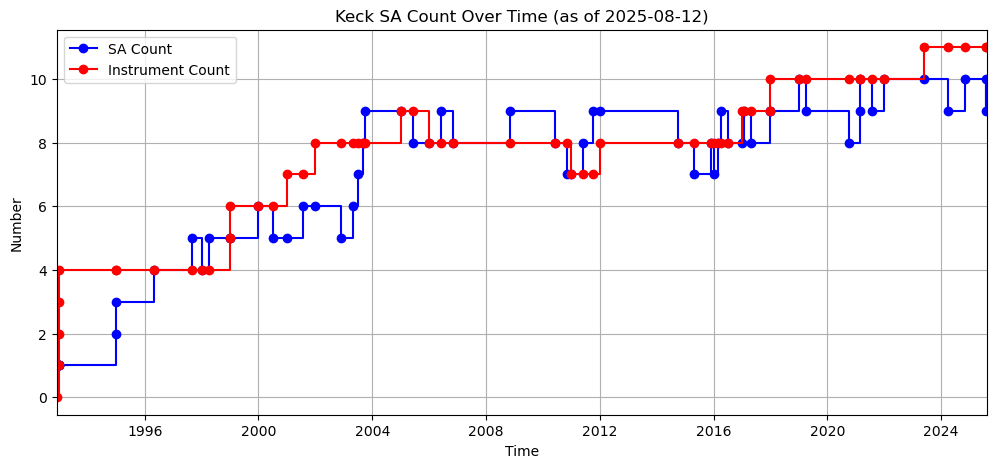

In [4]:
title = 'Keck SA Count Over Time'
plt.figure(figsize=(12,5))
plt.title(f"{title} (as of {now_str})")
plt.plot(events['date'], events['SA Count'], 'bo-', drawstyle='steps-post',
         label='SA Count')
plt.plot(events['date'], events['Instrument Count'], 'ro-', drawstyle='steps-post',
         label='Instrument Count')
plt.ylabel('Number')
plt.xlabel('Time')
plt.xlim(SAs[0]['Start'], now)
plt.grid()
plt.legend(loc='best')
plt.savefig(f'{title}.png')
plt.show()

In [5]:
def generate_plot(SAs, title):
    plt.figure(figsize=(10,8))
    plt.title(f"{title} (as of {now_str})")

    if 'Short Name' in SAs.keys():
        names = [f"{entry['Short Name']} ({entry['Duration']:.1f} yr)" for entry in SAs]
    else:
        names = [f"{entry['Name']} ({entry['Duration']:.1f} yr)" for entry in SAs]
    
    plt.barh(names, SAs['Duration'],
             left=[(SA['Start'] - min(SAs['Start'])).days/365 for SA in SAs],
             color=[{'operational': 'g', 'SA': 'g', 'transfer': 'y', 'depart': 'r', 'decommissioned': 'r'}[s] for s in SAs['Status']],
             label=SAs['Duration'],
             alpha=0.4)
    plt.xlabel('Years')
    plt.grid(axis='y')
    plt.savefig(f'{title}.png')
    plt.show()

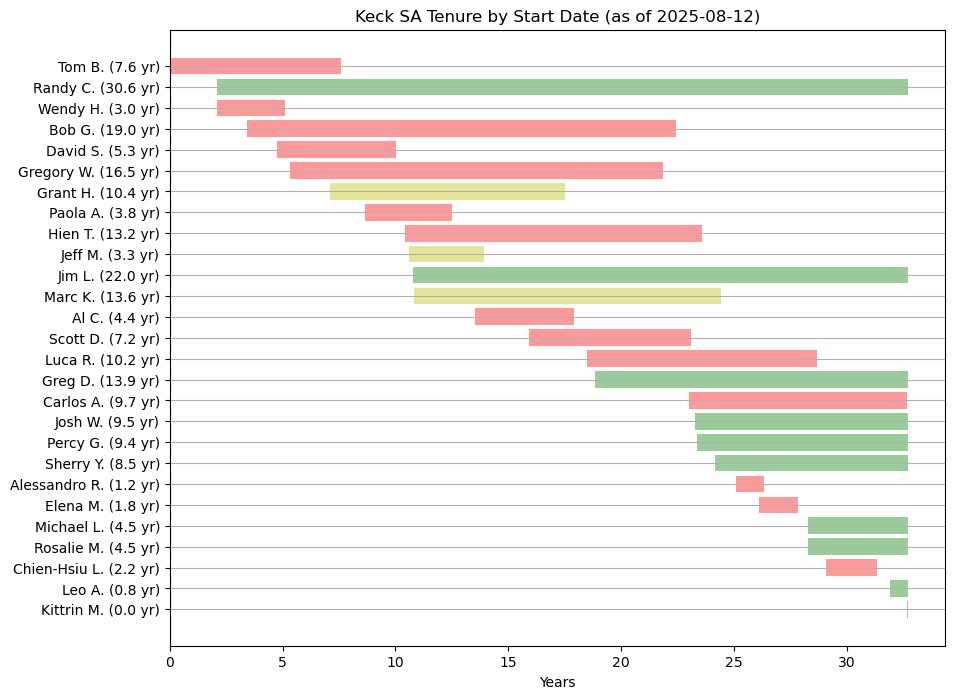

In [6]:
SAs.sort('Start', reverse=True)
generate_plot(SAs, 'Keck SA Tenure by Start Date')

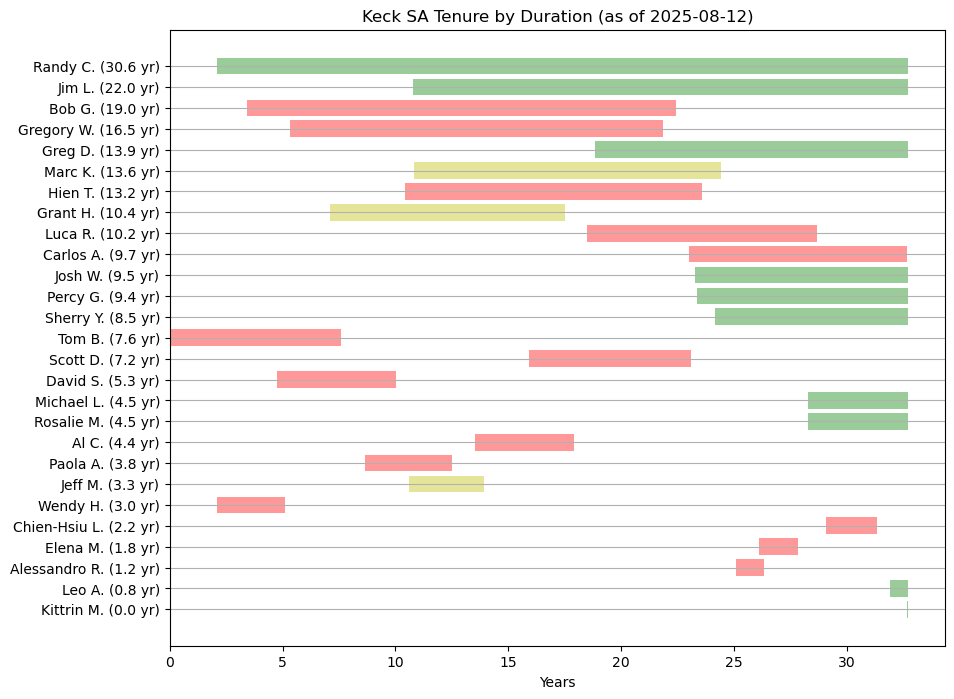

In [7]:
SAs.sort('Duration', reverse=False)
generate_plot(SAs, 'Keck SA Tenure by Duration')

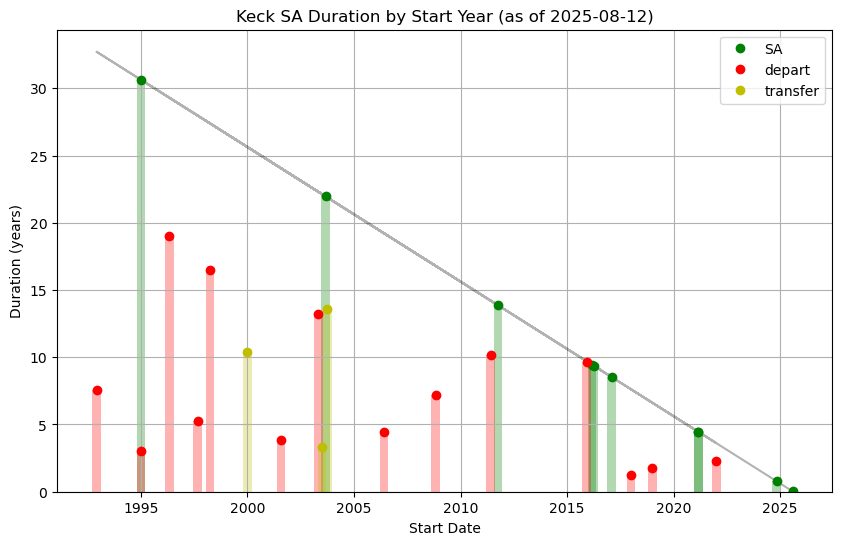

In [8]:
title = 'Keck SA Duration by Start Year'
bystatus = SAs.group_by('Status')
plt.figure(figsize=(10,6))
plt.title(f"{title} (as of {now_str})")
max_duration = [(now - sa['Start']).days/365 for sa in SAs]
start_decimal = [(float(d.strftime("%j"))-1) / 366 + float(d.strftime("%Y")) for d in SAs['Start']]
plt.plot(start_decimal, max_duration, 'k-', alpha=0.3)
colors = {'SA': 'g', 'transfer': 'y', 'depart': 'r'}
for i,group in enumerate(bystatus.groups):
    status = group[0]['Status']
    start_decimal = [(float(d.strftime("%j"))-1) / 366 + float(d.strftime("%Y")) for d in group['Start']]
    plt.bar(start_decimal, group['Duration'], color=colors[status], width=0.4, alpha=0.3)
    plt.plot(start_decimal, group['Duration'], f'{colors[status]}o', label=status)
plt.xlabel('Start Date')
plt.ylabel('Duration (years)')
plt.legend(loc='best')
plt.grid()
plt.savefig(f'{title}.png')
plt.show()

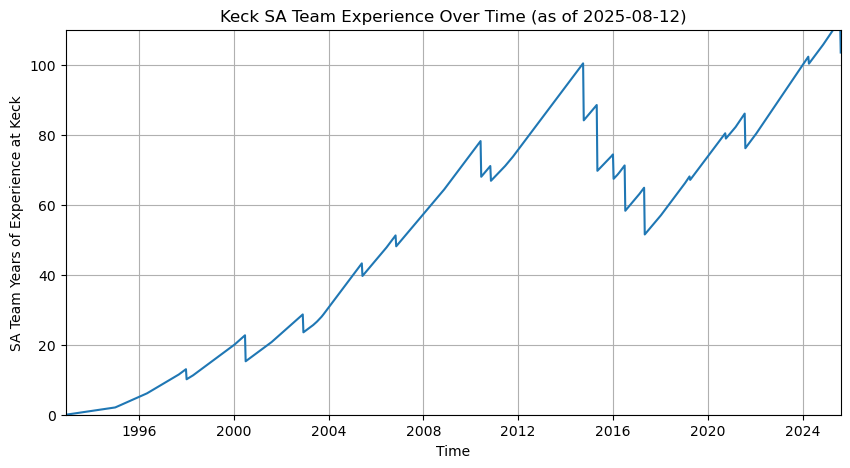

In [9]:
SAs.sort('Start', reverse=False)
title = 'Keck SA Team Experience Over Time'

increment = timedelta(days=10)
x_dates = []
y_years = []
now = datetime.now()
date = SAs[0]['Start']
while date < now-increment:
    date += increment
    x_dates.append(date)
    experience = 0
    for SA in SAs:
        if SA['Start'] < date:
            this_sa_duration = (date-SA['Start']).days/365
            if this_sa_duration < SA['Duration']:
                experience += this_sa_duration
    y_years.append(experience)

plt.figure(figsize=(10,5))
plt.plot(x_dates, y_years)
plt.ylim(0,110)
plt.title(f"{title} (as of {now_str})")
plt.ylabel('SA Team Years of Experience at Keck')
plt.xlabel('Time')
plt.xlim(SAs[0]['Start'], now)
plt.grid()
plt.savefig(f'{title}.png')
plt.show()

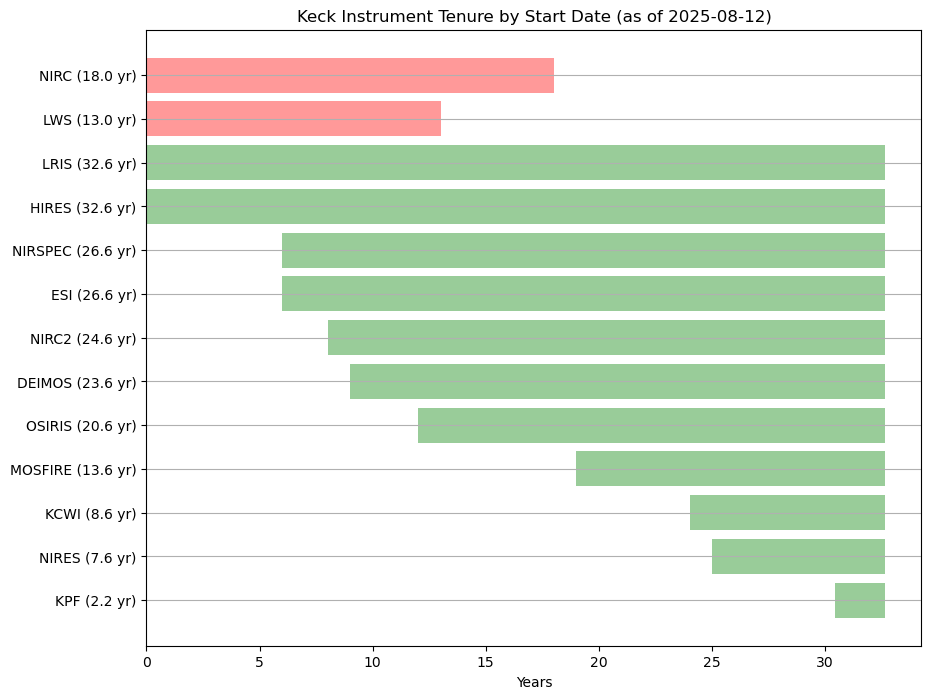

In [10]:
instruments.sort('Start', reverse=True)
generate_plot(instruments, 'Keck Instrument Tenure by Start Date')

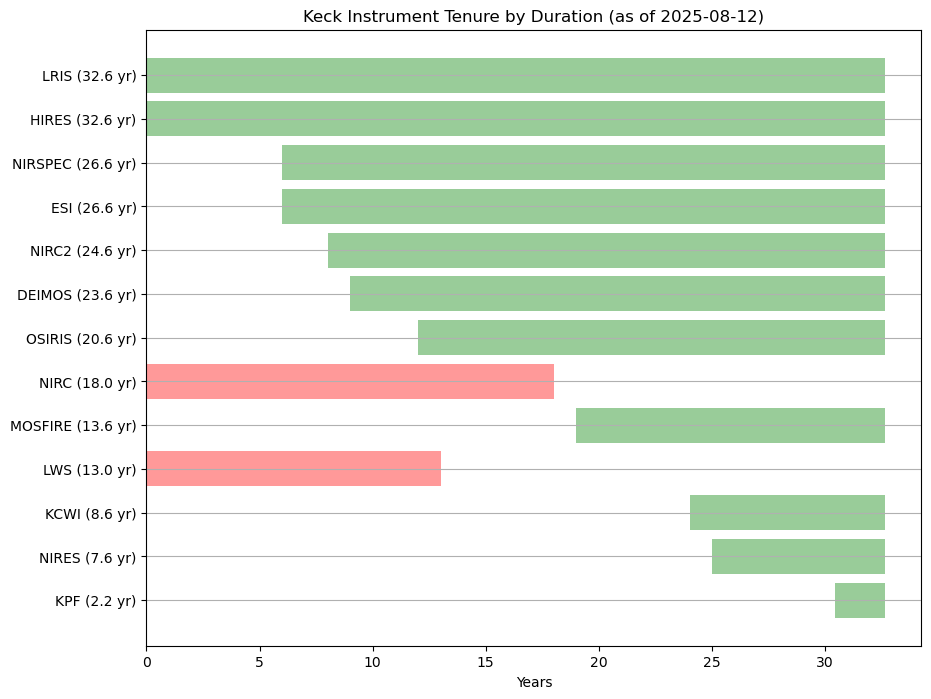

In [11]:
instruments.sort('Duration', reverse=False)
generate_plot(instruments, 'Keck Instrument Tenure by Duration')